Berner Fachhochschule BFH - MAS Data Science - Graph Machine Learning - Master Thesis FS/2022 Thomas Iten

# 13. Graph SAGE Link Prediction mit Subject als Features

**Inhalt**
1. Cora Datenset laden inklusive Features
2. Test- und Trainingsdaten aufbereiten
3. Link Generator definieren
4. Model erstellen
5. Model trainieren
6. Test Performance

**Referenzen**<br />
[1] http://snap.stanford.edu/graphsage/<br />
[2] https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html<br />
[3] Stamile, Marzullo, Deusebio. Graph Machine Learning. Packt Publishing 2021. ISBN 978-1-80020-449-2


In [1]:
import numpy as np

from tensorflow import keras
from sklearn import metrics

import stellargraph as sg
from stellargraph import datasets
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

from IPython.display import display, HTML

## 13.1 Cora Datenset laden inklusive Features
Laden der Cora Daten direkt mit Hilfe der Datasets Klasse. Jeder Node repräsentiert ein Schreiben. Mit dem Parameter subject_as_feature True wird das Thema (Subject) direkt als Node Feature mitgeliefert.

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, _ = dataset.load(subject_as_feature=True)

print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


## 13.2 Test- und Trainigsdaten aufbereiten
Für die Aufteilung der Daten wird die Klasse EdgeSplitter aus dem stellargraph.data Package verwendent.

**Testdaten**

Als erstes werden aus dem gesammten Graphen einen Teilgraphen sowie eine Liste von Verbindungen und Labels für die Tests generiert.
- test_graph   : Subset von original Graphen mit allen Knoten aber nur einem Teil der Verbindungen
- test_samples : Liste mit Knotenpaaren mit realen Verbindungen (positive edges) und Knotenpaaren die keine Verbindungen haben (negative edges)
- test_labels  : Liste mit den Labeln passend zu den Knotenpaaren der Testdaten

In [3]:
edgeSplitter = EdgeSplitter(graph)
test_graph, test_samples, test_labels  = edgeSplitter.train_test_split(p=0.1, method="global", keep_connected=True)

** Sampled 542 positive and 542 negative edges. **


**Trainingsdaten**

Das gleich wird anschliessend für die Trainingsdaten gemacht. Bei der Initialisierung der EdgeSplitter Klassen wird zusätzlich der erstellte test_graph übergeben, so dass die Trainings- und Testdaten nicht überschneiden.

In [4]:
edgeSplitter = EdgeSplitter(test_graph, graph)
train_graph, train_samples, train_labels = edgeSplitter.train_test_split(p=0.1, method="global", keep_connected=True)

** Sampled 488 positive and 488 negative edges. **


## 13.3 Link Generator definieren
Mit Hilfe des GraphSageLinkGenerator wird für die Trainigs- und Testdaten je ein Flow Objekt erzeugt. Diese liefert die Knoten Paarweise und wird  für das Model Training und die Vorhersagen verwendet.

Die num_samples Liste gibt die Anzahl der zu entnehmenden Nachbarknotenproben pro GraphSAGE-Schicht (hop) an. Wir haben zwei Schichten à jeweils 4 Proben. Die batch_size definiert die Anzahl Links welche pro Batch verarbeitet werden sollen.

In [5]:
batch_size = 64
num_samples = [4, 4]

train_gen  = GraphSAGELinkGenerator(train_graph, batch_size, num_samples)
train_flow = train_gen.flow(train_samples, train_labels, shuffle=True, seed=24)

test_gen   = GraphSAGELinkGenerator(test_graph, batch_size, num_samples)
test_flow  = test_gen.flow(test_samples, test_labels, seed=24)

## 13.4 Model erstellen

Nun erstellen wir ein GraphSAGE Modell mit zwei versteckten Schichten der Größe 20, einem Bias-Term und einer Dropout-Schicht zur Reduzierung von Overfitting. Diese wird mit einer Link Klassifizierungschicht verknüpft. Die Edge Embedding Methode 'ip' steht für Inner Product (es sind auch noch andere wie Hadamard, L1, L2 oder Avg möglich). Damit wird schliesslich ein vollständiges Keras Model mit einen Adam Optimierer erzeugt. Als Loss Funktion wird MSE (mean squared error) eingesetzt.

In [6]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes,
    generator=train_gen,
    bias=True,
    dropout=0.3)

x_inp, x_out = graphsage.in_out_tensors()
prediction   = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.mse,
    metrics=["acc"],
)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


## 13.5 Model trainieren

Nun wird das Modell mit den Testdaten (test_flow) mit der angegebenen Anzahl Epochen trainiert.

In [7]:
epochs = 24
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/24
16/16 [==============================] - 3s 94ms/step - loss: 0.2436 - acc: 0.5615 - val_loss: 0.2318 - val_acc: 0.5950
Epoch 2/24
16/16 [==============================] - 1s 73ms/step - loss: 0.2343 - acc: 0.6148 - val_loss: 0.2234 - val_acc: 0.6365
Epoch 3/24
16/16 [==============================] - 1s 75ms/step - loss: 0.2244 - acc: 0.6803 - val_loss: 0.2165 - val_acc: 0.6771
Epoch 4/24
16/16 [==============================] - 1s 74ms/step - loss: 0.2156 - acc: 0.6988 - val_loss: 0.2141 - val_acc: 0.6642
Epoch 5/24
16/16 [==============================] - 1s 75ms/step - loss: 0.2088 - acc: 0.7398 - val_loss: 0.2079 - val_acc: 0.6808
Epoch 6/24
16/16 [==============================] - 1s 75ms/step - loss: 0.2021 - acc: 0.7643 - val_loss: 0.2041 - val_acc: 0.7002
Epoch 7/24
16/16 [==============================] - 1s 82ms/step - loss: 0.1936 - acc: 0.7807 - val_loss: 0.2018 - val_acc: 0.7066
Epoch 8/24
16/16 [==============================] - 1s 79ms/step - loss: 0.1881 - a

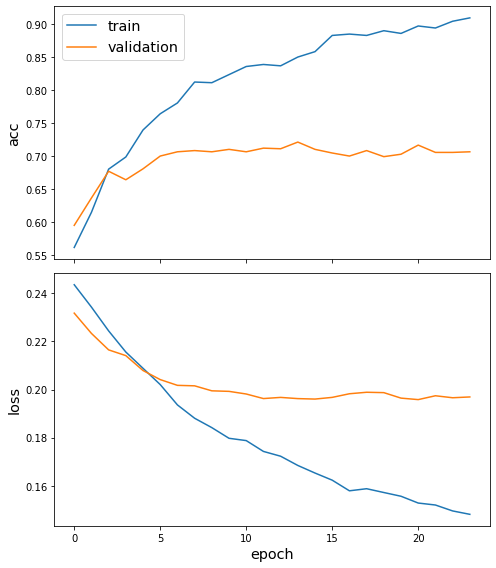

In [8]:
sg.utils.plot_history(history)

## 13.6 Test Performance
Nun kann das trainierte Modell für die Vorhersagen genutzt werden. Dazu messen wir die Performance der Trainings- und Testdaten.

In [9]:
def evaluate_metrics(title, labels, y_pred):
    print(title)
    print("- Precision =", metrics.precision_score(labels, y_pred))
    print("- Recall    =", metrics.recall_score(labels, y_pred))
    print("- F1-Score  =", metrics.f1_score(labels, y_pred))
    print()

y_pred = np.round(model.predict(train_flow)).flatten()
evaluate_metrics("Performance Training Set:", train_labels, y_pred)

y_pred = np.round(model.predict(test_flow)).flatten()
evaluate_metrics("Performance Test Set:", test_labels, y_pred)

Performance Training Set:
- Precision = 0.4888888888888889
- Recall    = 0.5409836065573771
- F1-Score  = 0.5136186770428016

Performance Test Set:
- Precision = 0.6465295629820051
- Recall    = 0.9280442804428044
- F1-Score  = 0.7621212121212121



---
_The end._